In [1]:
import numpy as np
import copy
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras import regularizers
from keras import backend as K
import Data_prep as dp
from scipy.io import savemat, loadmat
from keras.losses import mse, binary_crossentropy
from keras.layers import Reshape, Lambda, Input, Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
K.set_image_data_format('channels_last')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.io
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from keras import backend
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from matplotlib import pyplot
from keras.constraints import Constraint
import tensorflow as tf

In [3]:
def normalize(data):
    
    max_=np.max(data, axis=0)
    min_=np.min(data, axis=0)
    mean_=np.mean(data,axis=0)
    std_=np.std(data,axis=0)
    
    return np.divide((data-mean_),(std_))

In [4]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.multiply(y_true, y_pred))

class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

def generator(latent_dim):

    #decoder network:
    l_decode=0.0
    #input/BC:
    latent_input = Input(shape=(latent_dim,), name='latent_decode') #input
    x = latent_input
    init = RandomNormal(stddev=0.02)
    #fully connected layer 1:
    x = Dense(1000, kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 1)(x)
    x = LeakyReLU(alpha=0.2)(x)

    #fully connected layer 2:
    x = Dense(5000, kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 1)(x)
    x = LeakyReLU(alpha=0.2)(x)

    #reshaping:
    x = Reshape((10, 125, 4))(x)

    #CNN/upsampling layer 1:
    x = Conv2DTranspose(4, (5, 5), strides = (1, 1), padding='same', kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 3)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2), interpolation = 'bilinear')(x)
    #x = AveragePooling2D((2, 2), padding='same')(x)
    x = Conv2DTranspose(4, (5, 5), strides = (1, 1), padding='same', kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 3)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2), interpolation = 'bilinear')(x)
    #x = AveragePooling2D((2, 2), padding='same')(x)
    #output:
#     x = Conv2D(1, (9, 9), padding='same', strides = (4, 4), kernel_initializer=init)(x)
#     x = BatchNormalization(axis = 3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    outputs = Conv2DTranspose(1, (9, 9), padding='same', strides = (1, 1), kernel_initializer=init, activation = 'tanh', name='bathymetry')(x)
    #outputs = UpSampling2D((2, 2))(x)
    #set decoder model:
    decoder = Model([latent_input], outputs, name='decoder')
    return decoder 


In [5]:
def critic(in_shape=(40, 500, 1)):

    #decoder network:
    l_decode=0.0
    #input/BC:
    inputs = Input(shape=in_shape) #input
    const = ClipConstraint(100000)
    init = RandomNormal(stddev=0.1)
    y = inputs
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)
    y = Dense(1024)(y)
    y = BatchNormalization(axis = 1)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Flatten()(y)
    y = Dense(512)(y)
    y = BatchNormalization(axis = 1)(y)
    y = LeakyReLU(alpha=0.2)(y)
    outputs = Dense(1, activation = 'sigmoid')(y)
    #y = BatchNormalization(axis = 1)(y)
    #outputs = LeakyReLU(alpha=0.2)(y)
    #set critic model:
    critic = Model([inputs], [outputs])
    opt = Adam(lr=0.0002, beta_1=0.5)
    critic.compile(loss='binary_crossentropy', optimizer=opt)
    return critic 


In [6]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model(gen_output)
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise], [gan_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [7]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X = images[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #x_input = tf.random.normal(latent_dim * n_samples)
    z_input = tf.random.normal([n_samples, latent_dim]) 
    return [z_input]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images], y

In [8]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss1 = 0 
    d_loss2 = 0
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            real_iter = 1
            if (d_loss1 > 0):
                real_iter = 1
            fake_iter = 1
            if (d_loss2 > 0):
                real_iter = 1
            for k in range(real_iter):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, n_batch)
                # update discriminator model weights
                d_loss1 = d_model.train_on_batch([X_real], y_real)
                # generate 'fake' examples
            for kk in range(real_iter):
                [X_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
                # update discriminator model weights
                d_loss2 = d_model.train_on_batch([X_fake], y_fake)
                # prepare points in latent space as input for the generator
                [z_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input], [y_gan])
            ####
            d_loss1 = d_model.test_on_batch([X_real], y_real)
            d_loss2 = d_model.test_on_batch([X_fake], y_fake)
            g_loss = gan_model.test_on_batch([z_input], [y_gan])
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

In [9]:
def train_c(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss1 = 0 
    d_loss2 = 0
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print(i + j)
            real_iter = 1
            if (d_loss1 > 0):
                real_iter = 1
            fake_iter = 1
            if (d_loss2 > 0):
                real_iter = 1
            for k in range(real_iter):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, n_batch)
                # update discriminator model weights
                d_loss1 = d_model.train_on_batch([X_real], y_real)
            # generate 'fake' examples
            for kk in range(real_iter):
                [X_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
                # update discriminator model weights
                d_loss2 = d_model.train_on_batch([X_fake], y_fake)
            # prepare points in latent space as input for the generator
            [z_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            ####
            d_loss1 = d_model.test_on_batch([X_real], y_real)
            d_loss2 = d_model.test_on_batch([X_fake], y_fake)
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2))

In [10]:
def train_g(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # prepare points in latent space as input for the generator
            [z_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            # create inverted labels for the fake samples
            g_loss = gan_model.train_on_batch([z_input], [y_gan])
            ####
            g_loss = gan_model.test_on_batch([z_input], [y_gan])
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f' %(i+1, j+1, bat_per_epo, g_loss))

In [11]:
data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6.mat')
vel = data['velocity_prof'] #velocities
z_f = data['z_f'] #free surface elevation
Q_b = data['Q_b'] #influx
Z = data['Z'] #bathymetry
vx, vy, _ = dp.xy_vel_sep(vel) #v_x/v_y separation
data_z = np.reshape(Z.T, (4500, 41, 501, 1))
data_z = data_z[:, :40, :500, :]
std_ = np.reshape(np.std(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
mean_ = np.reshape(np.mean(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
min_ = np.reshape(np.min(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
max_ = np.reshape(np.max(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
data_zn = ((data_z - min_) / (max_ - min_))
data_zn = (data_zn - 0.5) * 2

In [12]:
g_model = generator(50)
c_model = critic()
gan_model = define_gan(g_model, c_model)
#train(g_model, c_model, gan_model, data_zn, 50, n_epochs=100, n_batch=128)

In [ ]:
epo = 100
for k in range(epo):
    #g_model = generator(50)
    num_sample = data_zn.shape[0]
    fake_samples = generate_fake_samples(g_model, 50, num_sample)[0][0]
    x_train = np.concatenate((fake_samples, data_zn))
    y_train = np.concatenate((np.zeros((num_sample, 1)), (np.ones((num_sample, 1)))))
    r_index = np.random.permutation(num_sample * 2) - 1
    x_train = x_train[r_index, :, :, :]
    y_train = y_train[r_index, :]
    n_epoch = 1
    for j in range(n_epoch):
        for i in range(282):
            c_model.train_on_batch(x_train[i * 16 : (i + 1) * 16], y_train[i * 16 : (i + 1) * 16])
            c_model.evaluate(x_train[i * 16 : (i + 1) * 16], y_train[i * 16 : (i + 1) * 16])
    train_g(g_model, c_model, gan_model, data_zn, 50, n_epochs=2, n_batch=128, n_steps = 10)

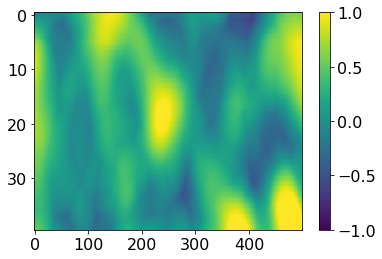

In [70]:
im = generate_real_samples(data_zn, 10)[0][0]
#plt.figure(figsize=(40,4))
plt.imshow(im[0,:,:,0], aspect='auto', vmin = -1, vmax = 1)
plt.colorbar()

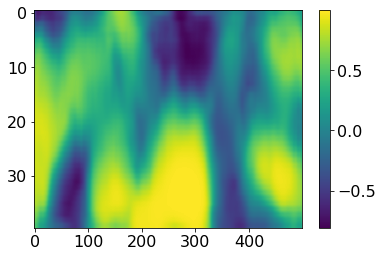

In [72]:
im = generate_fake_samples(g_model, 50, 10)[0][0]
#im = ((im / 2) + 0.5) * (max_ - min_) + min_
#plt.figure(figsize=(50,5))
plt.imshow(im[0,:,:,0], aspect='auto')
plt.colorbar()

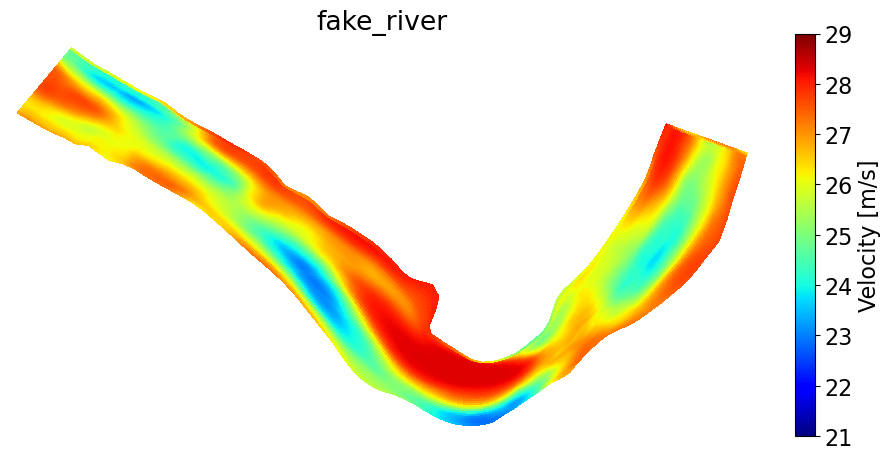

In [98]:
im = generate_fake_samples(g_model, 50, 10)[0][0]
im = ((im / 2) + 0.5) * (max_ - min_) + min_
fake_river = np.reshape(Z.T, (4500, 41, 501, 1))[0, :, :, 0]
fake_river[:40, :500] = im[0,:,:,0]
dp.plt_im_tri(depth=fake_river.ravel(), fig_title = 'fake_river', fig_name = 'fake_river_3.png')

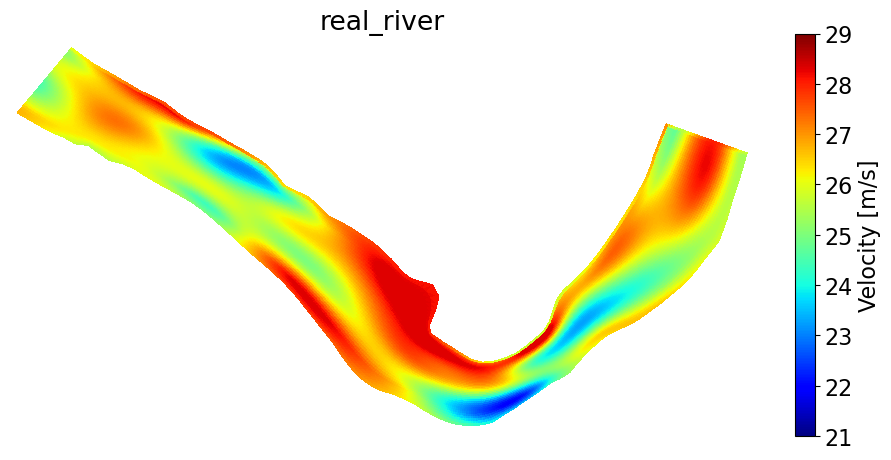

In [86]:
im = generate_real_samples(data_zn, 10)[0][0]
im = ((im / 2) + 0.5) * (max_ - min_) + min_
fake_river = np.reshape(Z.T, (4500, 41, 501, 1))[0, :, :, 0]
fake_river[:40, :500] = im[0,:,:,0]
dp.plt_im_tri(depth=fake_river.ravel(), fig_title = 'real_river', fig_name = 'real_river_3.png')

In [93]:
g_model.save_weights('Bathy_Generator_2.h5')

In [94]:
c_model.save_weights('Bathy_Critic_2.h5')